In [94]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [95]:
DATASET_PATH='./house-pricing.csv'
PREPARED_DATASET_PATH='./house-pricing-prepared.csv'


In [96]:
df = pd.read_csv(DATASET_PATH, sep=',')

# Fix types
df['DistrictId'] = df['DistrictId'].astype('int8')
df['HouseYear'] = df['HouseYear'].astype('int16')
df['HouseFloor'] = df['HouseFloor'].astype('int8')

# Transform categories to binary
df = pd.concat([
    df,
    pd.get_dummies(df['Ecology_2'], prefix='Ecology_2'),
    pd.get_dummies(df['Ecology_3'], prefix='Ecology_3'),
    pd.get_dummies(df['Shops_2'], prefix='Shops_2')
], axis=1)

df.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1, inplace=True)

df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,31.636000,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,1984.764700,0.118858,...,1142.904460,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,4859.01902,49.952628,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,53.112756,0.119025,...,1021.517264,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.00000,-128.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,-2005.000000,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,9.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1974.000000,0.017647,...,350.000000,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8394.50000,27.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1977.000000,0.075424,...,900.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12592.50000,61.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2001.000000,0.195781,...,1548.000000,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16798.00000,127.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,4968.000000,0.521867,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [97]:
def prepare_dataset(data: pd.DataFrame) -> pd.DataFrame:
    def prepare_square(d: pd.DataFrame) -> pd.DataFrame:
        d = d.drop(d[(d['Square'] > 200) & (d['Price'] < 200000)].index)
        d.drop(d[d['Square'] > 250].index)
        d.drop(d[d['Square'] <= 15].index, inplace=True)

        return d

    def prepare_house_data(d: pd.DataFrame) -> pd.DataFrame:
        def _fix_floor(row):
            if row['Floor'] > row['HouseFloor']:
                row['HouseFloor'] = row['Floor'] * 1.5

            return row

        d.loc[d['HouseFloor'] > 50, 'HouseFloor'] = d['HouseFloor'].median()
        d['HouseYear'] = d['HouseYear'].apply(np.abs)
        d.loc[(d['HouseYear'] > 2021) | (d['HouseYear'] < 1920), 'HouseYear'] = d['HouseYear'].median()
        d = d.apply(_fix_floor, axis=1)

        return d


    def prepare_kitchen_square(d: pd.DataFrame) -> pd.DataFrame:
        def _fix_square(row):
            square = row['KitchenSquare']

            if square < 5 or square > row['Square'] / 2:
                square = row['Square'] * 0.25

            if square < 5:
                square = 5

            row['KitchenSquare'] = square

            return row

        d = d.drop(d[d['KitchenSquare'] > d['Square']].index)
        d = d.drop(d[d['KitchenSquare'] > 100].index)

        return d.apply(_fix_square, axis=1)


    def prepare_life_square(d: pd.DataFrame) -> pd.DataFrame:
        def _fix_square(row):
            life_square = row['LifeSquare']

            if math.isnan(life_square) or life_square < 10 or (life_square + row['KitchenSquare']) > row['Square']:
                life_square = (row['Square'] - row['KitchenSquare']) * 0.7

            row['LifeSquare'] = life_square

            return row

        return d.apply(_fix_square, axis=1)


    def prepare_ecology(d: pd.DataFrame) -> pd.DataFrame:
        def _fix_ecology(row):
            if not row['Ecology_1'] > 0:
                region = row['DistrictId']

                ecology_1_series = d[d['DistrictId'] == region]['Ecology_1']
                ecology = ecology_1_series.mode()[0]

                row['Ecology_1'] = ecology

            return row

        return d.apply(_fix_ecology, axis=1)


    def prepare_healthcare(d: pd.DataFrame) -> pd.DataFrame:
        def _fix_healthcare(row):
            healthcare = row['Healthcare_1']

            if math.isnan(healthcare):
                healthcare_series = d[d['DistrictId'] == row['DistrictId']]['Healthcare_1']
                healthcare_modes = healthcare_series.mode()
                row['Healthcare_1'] = healthcare_modes[0] if len(healthcare_modes) else 0

            return row

        return d.apply(_fix_healthcare, axis=1)


    data['Rooms'] = data['Rooms'].apply(lambda rooms: rooms if 1 < rooms < 6 else data['Rooms'].median())
    data['DistrictId'] = data['DistrictId'].apply(np.abs)

    data = prepare_square(data)
    data = prepare_house_data(data)
    data = prepare_kitchen_square(data)
    data = prepare_life_square(data)
    data = prepare_ecology(data)
    data = prepare_healthcare(data)

    return data

df = prepare_dataset(df)
df.reset_index(inplace=True)

df

,index,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,0,11809.0,27.0,3.0,115.027311,73.519117,10.000000,4.0,10.0,2014.0,...,0.0,0.0,0.0,305018.871089,0.0,1.0,0.0,1.0,0.0,1.0
1,1,3013.0,22.0,2.0,39.832524,23.169223,8.000000,7.0,8.0,1966.0,...,1183.0,1.0,0.0,177734.553407,0.0,1.0,0.0,1.0,0.0,1.0
2,2,8215.0,1.0,3.0,78.342215,47.671972,10.000000,2.0,17.0,1988.0,...,240.0,3.0,1.0,282078.720850,0.0,1.0,0.0,1.0,0.0,1.0
3,3,2352.0,1.0,2.0,40.409907,21.215201,10.102477,10.0,22.0,1977.0,...,240.0,0.0,1.0,168106.007630,0.0,1.0,0.0,1.0,0.0,1.0
4,4,13866.0,94.0,2.0,64.285067,38.562517,9.000000,16.0,16.0,1972.0,...,100.0,0.0,6.0,343995.102962,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9972,9995,1260.0,61.0,2.0,49.090728,33.272626,6.000000,3.0,12.0,1981.0,...,80.0,1.0,9.0,119367.455796,0.0,1.0,0.0,1.0,0.0,1.0
9973,9996,16265.0,27.0,2.0,64.307684,37.038420,9.000000,13.0,19.5,1977.0,...,0.0,0.0,0.0,199715.148807,0.0,1.0,0.0,1.0,1.0,0.0
9974,9997,2795.0,78.0,2.0,29.648057,16.555363,5.000000,3.0,5.0,1958.0,...,165.0,1.0,5.0,165953.912580,0.0,1.0,0.0,1.0,0.0,1.0
9975,9998,14561.0,21.0,2.0,32.330292,22.326870,5.000000,3.0,9.0,1969.0,...,125.0,3.0,5.0,171842.411855,0.0,1.0,0.0,1.0,0.0,1.0


<AxesSubplot:>

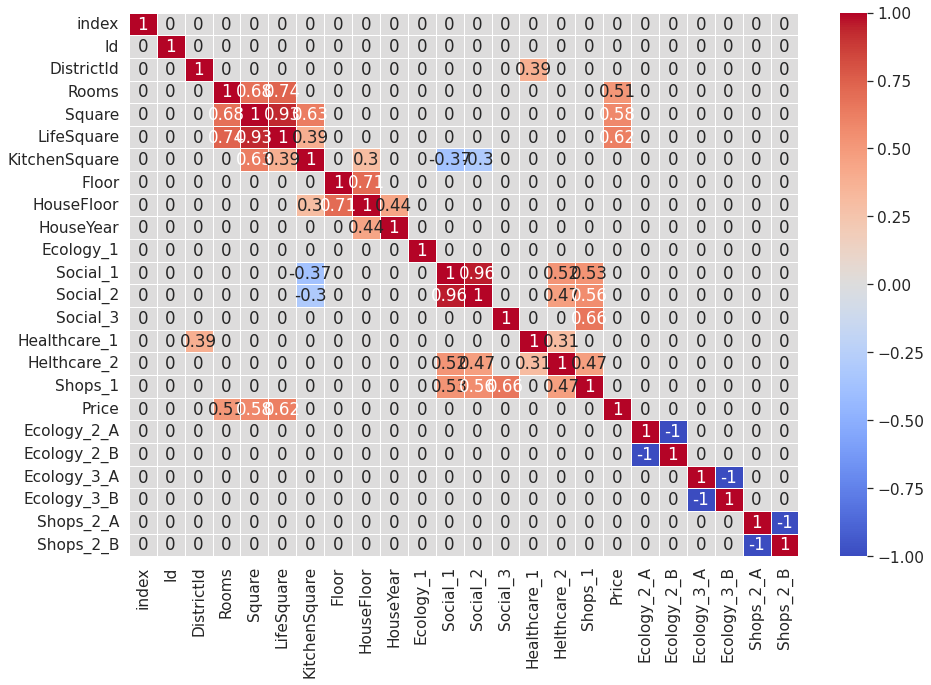

In [98]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='coolwarm')
